In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

In [2]:
df=pd.read_csv("E:\\model\\ratings_Beauty.csv")

In [3]:
df.columns=map(str.lower,df.columns)

In [4]:
df.head()

,userid,productid,rating,timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [5]:
display(df.sample(n=10, random_state=42))

,userid,productid,rating,timestamp
1909529,A2IL3S5JIMVU7G,B00DHG3KRY,5.0,1386979200
1602242,A33VGZOMZUOOG8,B007RNPAJO,1.0,1378512000
1181425,A3H1D1D0G80ZWA,B0047L3FRS,5.0,1367280000
1848825,A26XDAOZFABDKK,B00BNLHUPI,5.0,1372291200
961295,A12QIPKKP0OPOJ,B002ZW1RJY,4.0,1377820800
276429,A106OS4VJITJKG,B000GXGROY,5.0,1400976000
967069,A1R4ZIWPJ1K7AU,B0030UT4ZE,5.0,1304121600
955752,A3KEZLJ59C1JVH,B002YLCHK4,4.0,1352851200
392713,A29KFP3DPPM2PS,B000QUSAMO,3.0,1240790400
1300826,A1HE9MQR979OZQ,B004TSFB1M,5.0,1396310400


In [6]:
df=df.dropna()

In [7]:
df.head()

,userid,productid,rating,timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [8]:
df1=df.drop('timestamp',axis=1)

In [9]:
df1.head

<bound method NDFrame.head of                  userid   productid  rating
0        A39HTATAQ9V7YF  0205616461     5.0
1        A3JM6GV9MNOF9X  0558925278     3.0
2        A1Z513UWSAAO0F  0558925278     5.0
3        A1WMRR494NWEWV  0733001998     4.0
4        A3IAAVS479H7M7  0737104473     1.0
...                 ...         ...     ...
2023065  A3DEHKPFANB8VA  B00LORWRJA     5.0
2023066  A3DEHKPFANB8VA  B00LOS7MEE     5.0
2023067   AG9TJLJUN5OM3  B00LP2YB8E     5.0
2023068   AYBIB14QOI9PC  B00LPVG6V0     5.0
2023069  A1PB6OT0OOPKNQ  B00LU0LTOU     5.0

[2023070 rows x 3 columns]>

In [10]:
row,columns=df1.shape
print(row)
print(columns)

2023070
3


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userid     object 
 1   productid  object 
 2   rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


In [12]:
df.isnull().sum()

userid       0
productid    0
rating       0
timestamp    0
dtype: int64

# summary

In [13]:
df1['rating'].describe()

count    2.023070e+06
mean     4.149036e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

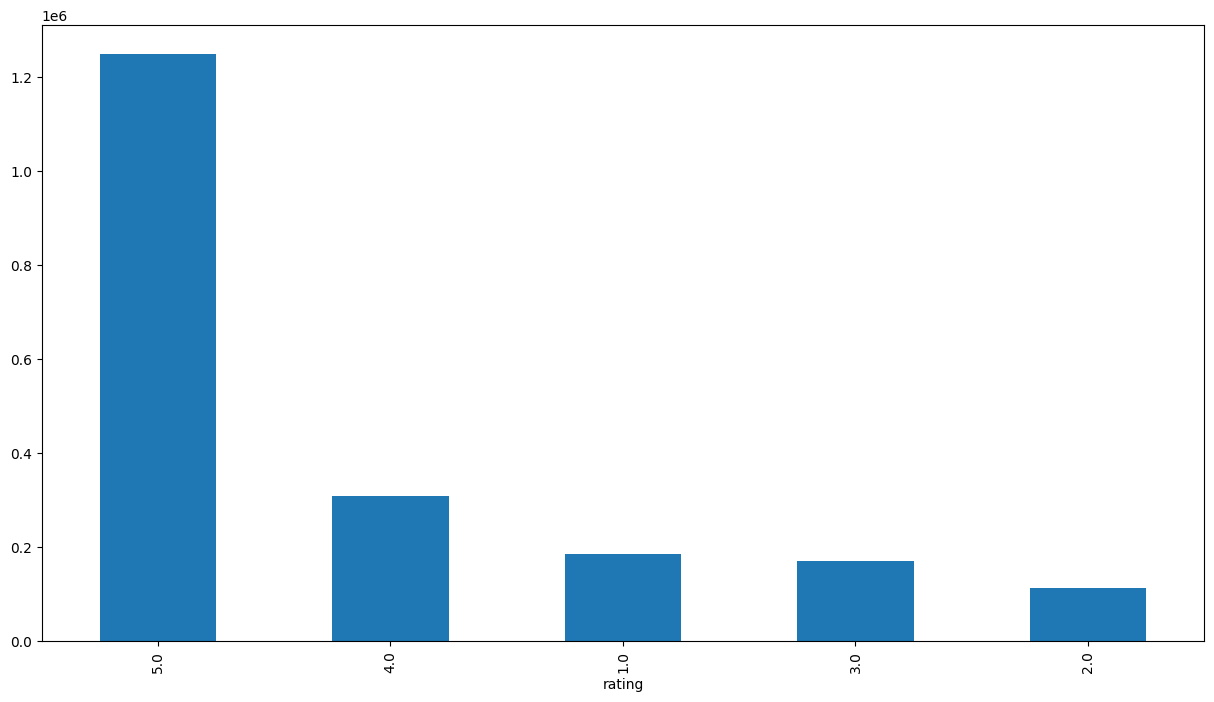

In [14]:
plt.figure(figsize=(15,8))
df1['rating'].value_counts().plot(kind='bar')
plt.show()

In [15]:
# check number of nunique values
print('Number of the nunique values user data:',df1['userid'].nunique())
print('number of the nunique value in user data',df1['productid'].nunique())

Number of the nunique values user data: 1210271
number of the nunique value in user data 249274


# more rating in user data

In [16]:
most_rate=df1.groupby('userid').size().sort_values(ascending=False)[:10]
print(most_rate)

userid
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
dtype: int64


## Pre-Processing

#Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [17]:
count_df=df1['userid'].value_counts()
df_final=df1[df1['userid'].isin(count_df[count_df >=20].index)]

In [18]:
df_final.head()

,userid,productid,rating
5,AKJHHD5VEH7VG,0762451459,5.0
6,A1BG8QW55XHN6U,1304139212,5.0
10,A1BG8QW55XHN6U,130414643X,5.0
19,A1BG8QW55XHN6U,1304174867,5.0
20,A1BG8QW55XHN6U,1304174905,5.0


In [19]:

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['userid'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['productid'].nunique())

The number of observations in the final data = 97860
Number of unique USERS in the final data =  2826
Number of unique PRODUCTS in the final data =  42042


#  this for who are more then 50 rating productid
# we will choose the product recommendation product

In [20]:
final=df_final.pivot_table(index='userid',columns='productid',values='rating').fillna(0)

In [21]:
final.shape

(2826, 42042)

In [22]:
final.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
userid,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A099766128UI0NCS98N1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100ZQDV7L8PVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A102JNFLL0KW7I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Finding the number of non-zero entries in the interaction matrix 
num_rating=np.count_nonzero(final)
print('give_num_rating',num_rating)

give_num_rating 97860


In [24]:
#Finding the possible number of ratings as per the number of users and products
possible_rating=final.shape[0] * final.shape[1]
print('possible in rating', possible_rating)

possible in rating 118810692


In [25]:
#Density of ratings
density=(num_rating/possible_rating)
density *=100
print('density : {:4.2f}%'.format(density))

density : 0.08%


In [26]:
final.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
userid,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A099766128UI0NCS98N1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100ZQDV7L8PVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A102JNFLL0KW7I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## user cosin similarity

In [27]:
##Rank Based Recommendation System

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97860 entries, 5 to 2023047
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     97860 non-null  object 
 1   productid  97860 non-null  object 
 2   rating     97860 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


In [29]:
df_final.head()

,userid,productid,rating
5,AKJHHD5VEH7VG,0762451459,5.0
6,A1BG8QW55XHN6U,1304139212,5.0
10,A1BG8QW55XHN6U,130414643X,5.0
19,A1BG8QW55XHN6U,1304174867,5.0
20,A1BG8QW55XHN6U,1304174905,5.0


In [30]:
average_rating=df_final['rating'].mean()

In [31]:
average_rating

4.189863069691396

In [32]:
count_rating = df_final.groupby('productid').count()['rating']

In [33]:
count_rating

productid
0762451459    1
1304139212    1
130414643X    1
1304174867    1
1304174905    1
             ..
B00LG63DOM    5
B00LH25A32    1
B00LH81A0I    1
B00LLPT4HI    5
B00LMOT7X4    1
Name: rating, Length: 42042, dtype: int64

In [34]:
av=df_final.groupby('productid')['rating'].mean().sort_values(ascending=False)

In [35]:
final_out=pd.DataFrame({'average_rating':av,'rating_count':count_rating})

In [36]:
final_out.head()

,average_rating,rating_count
productid,,
0762451459,5.0,1
1304139212,5.0,1
130414643X,5.0,1
1304174867,5.0,1
1304174905,5.0,1


In [37]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    recommedation=final_rating[final_rating['rating_count']> min_interaction]
    # sorte value
    recommedation=recommedation.sort_values('average_rating',ascending=False)
    
    return recommedation.index[:n]

##Recommending top 5 products with 50 minimum interactions based on popularity

In [38]:
list(top_n_products(final_out,5,22))

['B0061YRVMO', 'B006GTKSHY', 'B00KHH2VOY', 'B00KH6F6TM', 'B00IT1HKV4']

Recommending top 5 products with 100 minimum interactions based on popularity

In [39]:
list(top_n_products(final_out,5,100))

['B009YSSLAU', 'B00639DLV2', 'B009FKNGRA', 'B00A0J084Y', 'B008U2Y9BQ']

In [40]:
final_out.head()

,average_rating,rating_count
productid,,
0762451459,5.0,1
1304139212,5.0,1
130414643X,5.0,1
1304174867,5.0,1
1304174905,5.0,1


In [41]:
final

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
userid,,,,,,,,,,,,,,,,,,,,,
A03364251DGXSGA9PSR99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A099766128UI0NCS98N1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100ZQDV7L8PVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A102JNFLL0KW7I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZIDXJ9F7A83Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZIJ44I4NIO5M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMMFZKJB8PV6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
final['user_index']=np.arange(0,final.shape[0])
final.set_index(['user_index'],inplace=True)

In [43]:
final.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Function to find Similar users and their similarity scores

In [44]:
#  defining a function to get similar users
def similar_user(user_index,interactions):
    similarity=[]
    for user in  range(0,interactions.shape[0]):
        sim=cosine_similarity([interactions.loc[user_index]],[interactions.loc[user]])
        similarity.append((user,sim))
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
    return  most_similar_users,similarity_score
           

## Finding out top 10 similar users to the user index 3 and their similarity score

In [45]:
similer=similar_user(3, final)[0][0:10]
print(similer)

[1591, 1710, 673, 659, 91, 1908, 129, 1981, 1265, 728]


In [46]:
similar_user(3,final)[1][0:10]

[array([[0.14596725]]),
 array([[0.143499]]),
 array([[0.14118197]]),
 array([[0.12904335]]),
 array([[0.12165177]]),
 array([[0.11913869]]),
 array([[0.11730807]]),
 array([[0.11217961]]),
 array([[0.11113415]]),
 array([[0.10844601]])]

#Finding out top 10 similar users to the user index 1591 and their similarity score

In [47]:
similer=similar_user(1591,final)[0][0:10]
print(similer)

[2655, 1924, 1781, 2033, 246, 2379, 773, 2819, 905, 766]


In [48]:
#Print the similarity score
similar_user(1591,final)[1][0:10]

[array([[0.19679148]]),
 array([[0.1866314]]),
 array([[0.18634179]]),
 array([[0.18031013]]),
 array([[0.17350609]]),
 array([[0.1720455]]),
 array([[0.16610655]]),
 array([[0.16606521]]),
 array([[0.16394796]]),
 array([[0.1595271]])]

## Function to recommend products

In [49]:


def recommendations(user_index, num_of_products, interactions_matrix):
    def similar_user(user_index, interactions_matrix):
        similarity = []
        for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
            sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
            similarity.append((user,sim))
        
        similarity.sort(key=lambda x: x[1], reverse=True)
        most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
        similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
        most_similar_users.remove(user_index)
        similarity_score.remove(similarity_score[0])
       
        return most_similar_users, similarity_score
     
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_user(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]


In [50]:
recommendations(3,5 ,final)

['B00AE07FUO', 'B00GMWMMOW', 'B00BB8ZHJE', 'B00AO4E9E0', 'B00HM6IV6K']

Recommend 5 products to user index 3 based on similarity based collaborative filtering

Recommend 5 products to user index 1591 based on similarity based collaborative filtering

In [51]:
recommendations(1591,5,final)

['B00EA4MHN0', 'B00GTC0IY6', 'B0094C4XOO', 'B006RFZ9IK', 'B00FRDPNA2']

## Model based Collaborative Filtering: Singular Value Decomposition

We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition

Also, we will use k=50 latent features to predict rating of products

In [52]:
# csr matirx
from scipy.sparse import csr_matrix

In [53]:
final_rating=csr_matrix(final.values)

In [54]:
print(final_rating)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 97860 stored elements and shape (2826, 42042)>
  Coords	Values
  (0, 4490)	5.0
  (0, 5323)	2.0
  (0, 5996)	5.0
  (0, 7885)	5.0
  (0, 9259)	5.0
  (0, 9557)	5.0
  (0, 10032)	3.0
  (0, 12083)	5.0
  (0, 12101)	4.0
  (0, 12103)	4.0
  (0, 14089)	5.0
  (0, 15004)	3.0
  (0, 16275)	3.0
  (0, 17017)	5.0
  (0, 18356)	5.0
  (0, 20242)	4.0
  (0, 20246)	5.0
  (0, 20799)	3.0
  (0, 20803)	5.0
  (0, 20805)	4.0
  (0, 22498)	4.0
  (0, 23485)	4.0
  (0, 23894)	4.0
  (0, 24095)	3.0
  (0, 25015)	5.0
  :	:
  (2824, 29641)	3.0
  (2824, 30647)	5.0
  (2824, 30653)	4.0
  (2825, 1960)	5.0
  (2825, 7625)	4.0
  (2825, 12903)	4.0
  (2825, 15255)	3.0
  (2825, 15875)	4.0
  (2825, 16733)	4.0
  (2825, 17509)	5.0
  (2825, 18523)	5.0
  (2825, 18539)	5.0
  (2825, 21161)	5.0
  (2825, 22766)	5.0
  (2825, 24458)	3.0
  (2825, 29641)	5.0
  (2825, 30875)	5.0
  (2825, 34287)	5.0
  (2825, 35055)	5.0
  (2825, 36187)	5.0
  (2825, 37554)	2.0
  (2825, 37717)	5.0
  (2825, 377

SVD

In [55]:
# Singular Value Decomposition
U,s,Vt=svds(final_rating,k=50)
sigma=np.diag(s)

In [56]:
U.shape,sigma.shape

((2826, 50), (50, 50))

In [57]:
Vt.shape

(50, 42042)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

In [58]:
# predicting rating
all_user_rating=np.dot(np.dot(U,sigma),Vt)

pred_df=pd.DataFrame(abs(all_user_rating),columns=final.columns)
pred_df.head()


productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.001506,0.000036,0.000036,0.000036,0.000036,0.002244,0.000181,0.000181,0.000181,0.000181,...,0.007384,0.010183,0.000283,0.008425,0.004743,0.006189,0.000167,0.021951,0.001982,0.009496
1,0.002468,0.000050,0.000050,0.000050,0.000050,0.002334,0.000071,0.000071,0.000071,0.000071,...,0.022543,0.013386,0.000294,0.005372,0.035360,0.003862,0.000146,0.018728,0.013619,0.005496
2,0.019451,0.001556,0.001556,0.001556,0.001556,0.003359,0.000666,0.000666,0.000666,0.000666,...,0.003192,0.024681,0.002107,0.022081,0.071984,0.011040,0.000298,0.031592,0.190875,0.010901
3,0.008391,0.000230,0.000230,0.000230,0.000230,0.000892,0.000176,0.000176,0.000176,0.000176,...,0.002134,0.029626,0.000570,0.000353,0.010746,0.000605,0.000324,0.002337,0.017515,0.010288
4,0.000201,0.000016,0.000016,0.000016,0.000016,0.000293,0.000013,0.000013,0.000013,0.000013,...,0.000075,0.000261,0.000034,0.000609,0.000446,0.000377,0.000097,0.000308,0.001908,0.000621


In [59]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':  # for integers
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:  # for floats.
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [60]:
df_o=reduce_mem_usage(pred_df)

Mem. usage decreased to 226.61 Mb (75.0% reduction)


In [61]:
df_o.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.001506,0.000036,0.000036,0.000036,0.000036,0.002245,0.000181,0.000181,0.000181,0.000181,...,0.007385,0.010185,0.000283,0.008423,0.004742,0.006187,0.000167,0.021957,0.001982,0.009499
1,0.002468,0.000050,0.000050,0.000050,0.000050,0.002335,0.000071,0.000071,0.000071,0.000071,...,0.022537,0.013390,0.000294,0.005371,0.035370,0.003862,0.000146,0.018723,0.013618,0.005497
2,0.019455,0.001555,0.001555,0.001555,0.001555,0.003359,0.000666,0.000666,0.000666,0.000666,...,0.003191,0.024673,0.002108,0.022079,0.071960,0.011040,0.000298,0.031586,0.190918,0.010902
3,0.008392,0.000230,0.000230,0.000230,0.000230,0.000893,0.000176,0.000176,0.000176,0.000176,...,0.002134,0.029633,0.000570,0.000353,0.010750,0.000605,0.000324,0.002337,0.017517,0.010284
4,0.000201,0.000016,0.000016,0.000016,0.000016,0.000293,0.000013,0.000013,0.000013,0.000013,...,0.000075,0.000261,0.000034,0.000609,0.000446,0.000377,0.000097,0.000308,0.001907,0.000621


In [62]:
from scipy.sparse import coo_matrix

In [63]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Columns: 42042 entries, 0762451459 to B00LMOT7X4
dtypes: float16(42042)
memory usage: 226.6 MB


In [64]:
df_o=df_o.apply(pd.to_numeric,errors='coerce')

In [65]:
df_o=df_o.fillna(0)

In [66]:
df_o.dtypes

productid
0762451459    float16
1304139212    float16
130414643X    float16
1304174867    float16
1304174905    float16
               ...   
B00LG63DOM    float16
B00LH25A32    float16
B00LH81A0I    float16
B00LLPT4HI    float16
B00LMOT7X4    float16
Length: 42042, dtype: object

In [67]:
df_o=df_o.astype('float64')

In [68]:
pred_matrix=csr_matrix(df_o.values)

In [69]:
print(pred_matrix.shape)

(2826, 42042)


In [70]:
#Function to recommend products

In [71]:
def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

    
    
    

In [72]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_rating,pred_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
24451    0.882324
24457    0.806152
13923    0.757812
6044     0.737305
24458    0.674805
Name: user_predictions, dtype: float64


# Recommending top 10 products to user id 100

In [73]:
recommend_items(100,final_rating,pred_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
20349    0.004814
28227    0.004650
21500    0.004143
20337    0.003441
13923    0.003111
20354    0.003063
25776    0.002892
23173    0.002619
34499    0.002527
17413    0.002502
Name: user_predictions, dtype: float64


In [74]:
# Evaluating the model
final['user_index']=np.arange(0,final.shape[0])

In [75]:
final.set_index(final['user_index'],inplace=True)

In [76]:
final.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4,user_index
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [77]:
average_rating=final.mean()
average_rating.head()

productid
0762451459    0.001769
1304139212    0.001769
130414643X    0.001769
1304174867    0.001769
1304174905    0.001769
dtype: float64

In [78]:
pred_df.head()

productid,0762451459,1304139212,130414643X,1304174867,1304174905,1304351475,1304482596,1304482685,1304495396,1304511111,...,B00L4I5PJS,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH25A32,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.001506,0.000036,0.000036,0.000036,0.000036,0.002245,0.000181,0.000181,0.000181,0.000181,...,0.007385,0.010185,0.000283,0.008423,0.004742,0.006187,0.000167,0.021957,0.001982,0.009499
1,0.002468,0.000050,0.000050,0.000050,0.000050,0.002335,0.000071,0.000071,0.000071,0.000071,...,0.022537,0.013390,0.000294,0.005371,0.035370,0.003862,0.000146,0.018723,0.013618,0.005497
2,0.019455,0.001555,0.001555,0.001555,0.001555,0.003359,0.000666,0.000666,0.000666,0.000666,...,0.003191,0.024673,0.002108,0.022079,0.071960,0.011040,0.000298,0.031586,0.190918,0.010902
3,0.008392,0.000230,0.000230,0.000230,0.000230,0.000893,0.000176,0.000176,0.000176,0.000176,...,0.002134,0.029633,0.000570,0.000353,0.010750,0.000605,0.000324,0.002337,0.017517,0.010284
4,0.000201,0.000016,0.000016,0.000016,0.000016,0.000293,0.000013,0.000013,0.000013,0.000013,...,0.000075,0.000261,0.000034,0.000609,0.000446,0.000377,0.000097,0.000308,0.001907,0.000621


In [79]:
avg_pred=pred_df.mean()
avg_pred.head()

productid
0762451459    0.010902
1304139212    0.000189
130414643X    0.000189
1304174867    0.000189
1304174905    0.000189
dtype: float16

In [80]:
rams_df=pd.concat([average_rating,avg_pred],axis=1)
rams_df.columns=['Avt_acutal_rating', 'Avg_predicted_rating']
rams_df.head()

,Avt_acutal_rating,Avg_predicted_rating
productid,,
0762451459,0.001769,0.010902
1304139212,0.001769,0.000189
130414643X,0.001769,0.000189
1304174867,0.001769,0.000189
1304174905,0.001769,0.000189


In [81]:
rams_df.isnull().sum()
rams_df=rams_df.dropna()

In [82]:
rams_df.isnull().sum()

Avt_acutal_rating       0
Avg_predicted_rating    0
dtype: int64

In [83]:
RMSE=mean_squared_error(rams_df['Avt_acutal_rating'],rams_df['Avg_predicted_rating'],squared=False)
print(f'Rmse SVD model={RMSE}\n')

Rmse SVD model=0.006598001776980851



In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


In [85]:
pd=pd.read_csv("E:\\model\\product_descriptions.csv")

In [86]:
pd.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [87]:
pd.isnull().sum()

product_uid            0
product_description    0
dtype: int64

In [88]:
pd.duplicated().sum()

0

In [89]:
pd.shape

(124428, 2)

# feature covertions in numberical data and analysis

In [90]:
vect=TfidfVectorizer(stop_words='english')

In [91]:
x=vect.fit_transform(pd['product_description'])

In [92]:
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8256891 stored elements and shape (124428, 268559)>

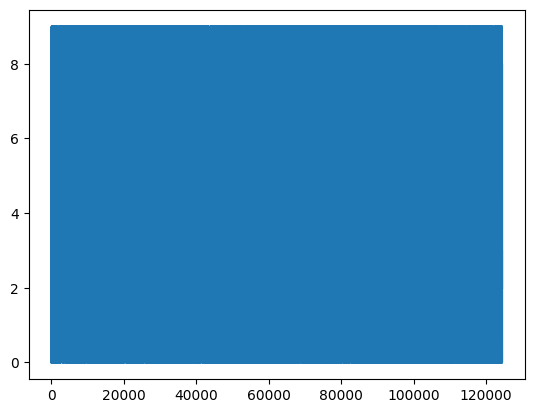

In [95]:
# this dataset is findout from the clustering
kmeans=KMeans(n_clusters=10, init='k-means++')
y_means=kmeans.fit_predict(x)
plt.plot(y_means)
plt.show()

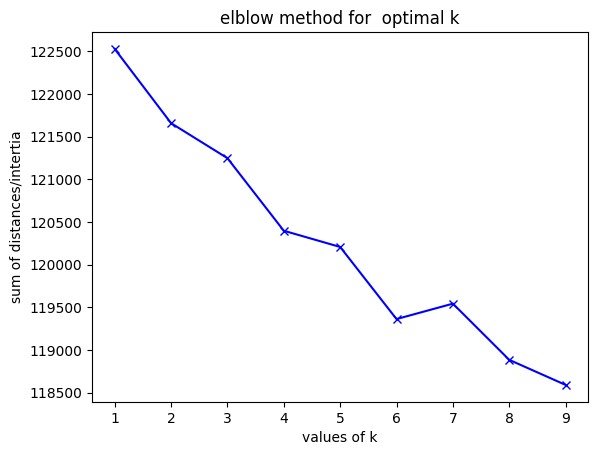

In [97]:
sum_of_distances=[]
k=range(1,10)
for num in k:
    kmeans=KMeans(n_clusters=num)
    kmeans.fit(x)
    sum_of_distances.append(kmeans.inertia_)
plt.plot(k,sum_of_distances,'bx-')
plt.xlabel('values of k')
plt.ylabel('sum of distances/intertia')
plt.title('elblow method for  optimal k')
plt.show()

In [96]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [99]:
from sklearn.metrics import silhouette_score,silhouette_samples

In [106]:
rang_clust=[2,3,4,5,6,7,8,9]
silhouette_avg=[]

for num_cluster in rang_clust:
    kmeans=KMeans(n_clusters=num_cluster)
    kmeans.fit(x)
    cluster_label=kmeans.labels_
    
    # silhouetter  score
    silhouette_avg.append(silhouette_score(x,cluster_label))
    plt.plot(rang_clust,silhouette_avg,'bx-')
    plt.xlabel('values of k')
    plt.ylabel('silhouette score')
    plt.title('silhouette score for optimal k')
    plt.show()

In [102]:
# # Optimal clusters is 
k=10
model=KMeans(n_clusters=k,init='k-means++',max_iter=100, n_init=1)
model.fit(x)
print('Top term of cluster ')
order_centroids=model.cluster_centers_.argsort()[:, ::-1]
terms=vect.get_feature_names_out()
for i in range(k):
    print_cluster(i)

Top term of cluster 
Cluster 0:
 steel
 used
 pipe
 pvc
 screws
 applications
 use
 head
 metal
 cutting
Cluster 1:
 water
 shower
 faucet
 sink
 valve
 drain
 brass
 handle
 tub
 bathroom
Cluster 2:
 cabinet
 vanity
 drawer
 storage
 adjustable
 door
 drawers
 wood
 shelf
 white
Cluster 3:
 rug
 tile
 indoor
 recommended
 vary
 slightly
 variation
 patterns
 residential
 thinset
Cluster 4:
 easy
 ft
 use
 wood
 home
 design
 steel
 durable
 wall
 finish
Cluster 5:
 paint
 color
 gloss
 colors
 mn
 ri
 fee
 ct
 ca
 states
Cluster 6:
 power
 air
 volt
 fan
 battery
 protection
 motor
 speed
 filter
 amp
Cluster 7:
 light
 watt
 bulb
 energy
 led
 lighting
 bulbs
 fixture
 incandescent
 glass
Cluster 8:
 door
 doors
 glass
 shower
 hardware
 steel
 panel
 tempered
 security
 hinges
Cluster 9:
 oven
 cooking
 cu
 freezer
 refrigerator
 food
 burner
 door
 temperature
 ft


In [103]:
def product_recommeand(product):
    y=vect.transform([product])
    prediction=model.predict(y)
    print_cluster(prediction[0])

In [104]:
product_recommeand("spray paint")

Cluster 5:
 paint
 color
 gloss
 colors
 mn
 ri
 fee
 ct
 ca
 states


In [105]:
product_recommeand("steel drill")

Cluster 0:
 steel
 used
 pipe
 pvc
 screws
 applications
 use
 head
 metal
 cutting
